In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler,SequentialSampler
import math

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [2]:
class Labels():
    def __init__(self,path):
        self.dataframe = pd.read_csv(path)
        self.override_params = True
        self.infotype = "Angle"
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        return self.dataframe.iloc[index][self.infotype]
    
    def histogram(self):
        return self.dataframe[self.infotype].hist()
        

In [9]:
class Images():
    def __init__(self,path, extension):
        self.path = path
        self.extension = extension
        
    def image_filename(self,path, number):
        return "{0}{number:06}".format(path,number=number)+"."+self.extension
        
    def get_stack(self,index,stack_size,stride):
        img_filenames = [self.image_filename(self.path,i) 
                         for i in range(index, index+stride*stack_size, stride)]
        images = np.array([io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames])
        images = np.concatenate(images, axis=0)
        return images
    
    def show(self,stack, channels=3):
        stack_size = len(stack)//channels
        stack = stack.squeeze()
        f, ax = plt.subplots(stack_size, channels, figsize=(12,4))
        ax = ax.reshape((stack_size,channels))
        for k in range(channels*stack_size):
            i,j = k//channels, k % channels
            ax[i,j].imshow(stack[k],cmap = 'gray', interpolation='bicubic')
            

In [10]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, 
                 stack_size = 1 ,
                 stride = 1,
                 batch_size = 64,
                 size = 0,
                 extension = "jpg",
                 img_folder = '../data/original/', 
                 csv_path = '../data/original/data.csv'):
        
        self.stack_size = stack_size
        self.stride = stride
        self.labels = Labels(csv_path)
        self.images = Images(img_folder,extension)
        
        self.make_dataloaders(batch_size, size)
    
    def make_dataloaders(self,batch_size, size = 0, train=0.5,test=0.5):
        if size == 0:
            size = len(self)
                
        indices = list(range(size))
        split = int(np.floor(test * size))
        end = int(np.floor((train+test) * size))
            
            
        # spliting the dataset
        train_indices, val_indices = indices[split:end], indices[:split]

        # Creating PT data samplers and loaders:
        
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Training data loader # NOTE had to remove shuffle
        self.dataloader = DataLoader(self, batch_size = batch_size, num_workers = 4, sampler=train_sampler)

        # Validation data loader # NOTE had to remove shuffle
        self.validloader = DataLoader(self, batch_size = batch_size, num_workers = 4, sampler=valid_sampler)

        print("Total training stacks", len(self.dataloader))
        print("Total validation stacks",len(self.validloader))
    
    def __len__(self):
        return len(self.labels) - self.stride*(self.stack_size-1)
    
    def __getitem__(self, idx):
        #get a stack of images
        image_stack = self.images.get_stack(idx,self.stack_size, self.stride)
        # use the latest image as the control
        label = self.labels[idx+ self.stride*(self.stack_size-1)]
        label = np.array([label])
        #combine stack and label together
        sample = {'image': image_stack, 
                  'control': label}
        return sample

Total training stacks 86
Total validation stacks 86
-----------------------
Rows are intervals of frames
Columns are color channels
-----------------------


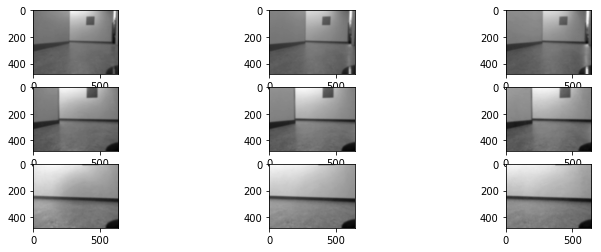

In [15]:
if __name__ == "__main__":
    dataset = ControlsDataset(stack_size = 3, stride = 50)
    img_stack = dataset[500]['image']
    print("-----------------------")
    print("Rows are intervals of frames")
    print("Columns are color channels")
    dataset.images.show(img_stack,channels=3)
    plt.show()

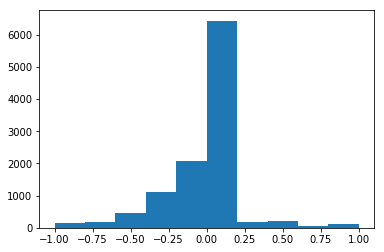

In [6]:
if __name__ == "__main__":
    counts = dataset.labels.dataframe.groupby('Angle')['ID'].count()
    print("Label Distirbution")
    a = plt.hist(dataset.labels.dataframe["Angle"])